In [1]:
using Pkg
Pkg.activate("..")

  Activating project at `~/repos/ProactiveHRI.jl`


In [ ]:
Pkg.update()
Pkg.instantiate()

In [179]:
include("dynamics.jl")
include("planner.jl")
include("planner_utils.jl")
include("utils.jl")
include("plotting.jl")
include("mpc.jl")
include("sim.jl")
include("experiments.jl")

simulation_sweep (generic function with 1 method)

In [77]:
dt = 0.1
velocity_max = 3.0
# human = SingleIntegratorPolar2D(dt, velocity_max, [pi, 2.])
human = Unicycle(dt, velocity_max, [1., 3.])

time_horizon = 25
# Q = zeros(Float64, human.state_dim, human.state_dim)
# R = diagm([0.; 0.1]) 
# Qt = diagm([10.; 10.])
Q = diagm([0.0; 0.0; 0.])
R = diagm([1.0; 0.1]) 
Qt = diagm([1.; 1.; 0.])
markup = 1.0
collision_slack = 350.
trust_region_weight = 5.
inconvenience_weights = [1.; 1.; 0.01]
collision_radius = 1.
inconvenience_ratio = 0.3


human_hps = PlannerHyperparameters(dynamics=human,
                             time_horizon=time_horizon,
                             Q=Q,
                             R=R,
                             Qt=Qt,
                             markup=markup,
                             collision_slack=collision_slack,
                             trust_region_weight=trust_region_weight,
                             inconvenience_weights=inconvenience_weights,
                             collision_radius=collision_radius,
                             inconvenience_ratio=inconvenience_ratio)



dt = 0.1
velocity_max = 3.0
# robot = Unicycle(dt, velocity_max, [1.0, 2.])
robot = DynamicallyExtendedUnicycle(dt, velocity_max, [1., 3.])

# time_horizon = 45
Q = diagm([0.0; 0.0; 0.; 0.])
R = diagm([1.; 0.1]) 
Qt = diagm([1.; 1.; 0.; 0.])

robot_hps = PlannerHyperparameters(dynamics=robot,
                             time_horizon=time_horizon,
                             Q=Q,
                             R=R,
                             Qt=Qt,
                             markup=markup,
                             collision_slack=collision_slack,
                             trust_region_weight=trust_region_weight,
                             inconvenience_weights=inconvenience_weights,
                             collision_radius=collision_radius,
                             inconvenience_ratio=inconvenience_ratio)


PlannerHyperparameters{Float64}
  dynamics: DynamicallyExtendedUnicycle{Float64}
  time_horizon: Int64 25
  Q: Array{Float64}((4, 4)) [0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0]
  R: Array{Float64}((2, 2)) [1.0 0.0; 0.0 0.1]
  Qt: Array{Float64}((4, 4)) [1.0 0.0 0.0 0.0; 0.0 1.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0]
  markup: Float64 1.0
  collision_slack: Float64 350.0
  trust_region_weight: Float64 5.0
  inconvenience_weights: Array{Float64}((3,)) [1.0, 1.0, 0.01]
  collision_radius: Float64 1.0
  inconvenience_ratio: Float64 0.3


In [106]:
robot_initial_state = [-10.; 0.; 0.; 2.]
robot_goal_state = [10.; 0.; 0.; 2.]
human_initial_state = [10.; 0.; pi]
human_goal_state = [-10.; 0.; pi]
solver = "ECOS"

ip = InteractionPlanner(robot_hps, 
                        human_hps,
                        robot_initial_state,
                        human_initial_state,
                        robot_goal_state,
                        human_goal_state,
                        solver)
# 
# ip = InteractionPlanner(human_hps, 
#                         robot_hps,
#                         human_initial_state,
#                         robot_initial_state,
#                         human_goal_state,
#                         robot_goal_state,
#                         solver)

InteractionPlanner
  ego_planner: AgentPlanner
  other_planner: AgentPlanner


# Multi Agent Support

In [107]:
ip = InteractionPlanner(robot_hps, 
                        human_hps,
                        robot_initial_state,
                        human_initial_state,
                        robot_goal_state,
                        human_goal_state,
                        solver)
# constant velo agents
velo_agent_1 = ConstantVeloAgent([5., -1.], [-0.3, 1.1])
velo_agent_2 = ConstantVeloAgent([6.5, -2.], [-0.9, 0.4])

add_constant_velocity_agent(ip.ego_planner.incon, velo_agent_1, velo_agent_2)
add_constant_velocity_agent(ip.other_planner.incon, velo_agent_1, velo_agent_2)

In [108]:
@time ibr(ip, 3, "ego", velo_agent_1, velo_agent_2)

  0.063670 seconds (269.37 k allocations: 24.163 MiB, 15.08% gc time)


InteractionPlanner
  ego_planner: AgentPlanner
  other_planner: AgentPlanner


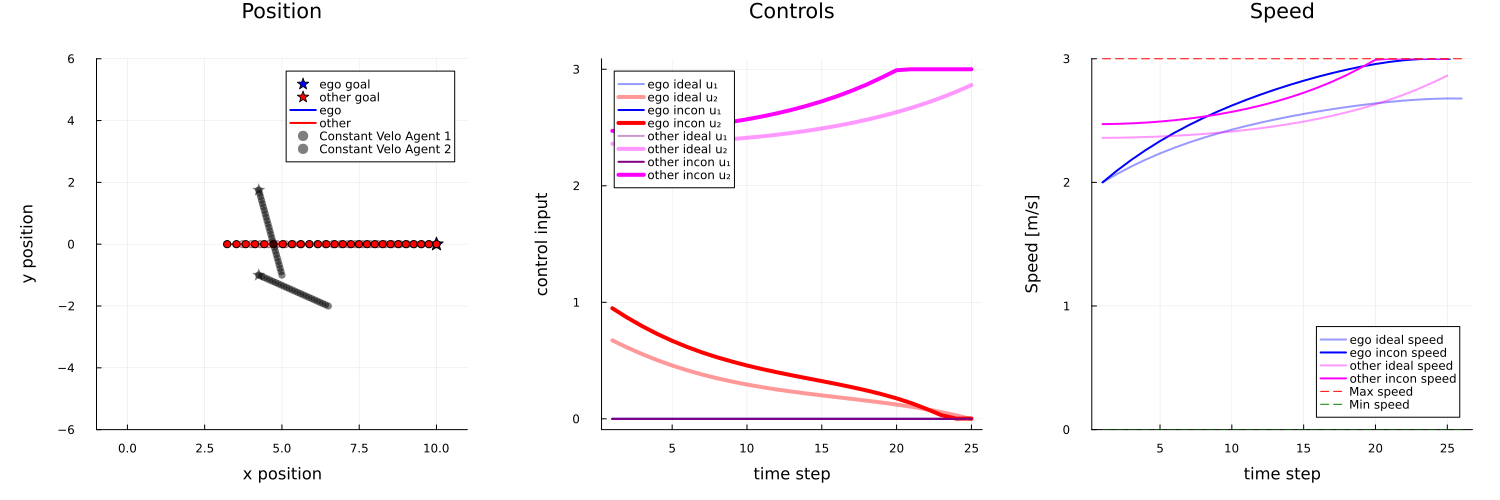

In [109]:
plot_solve_solution(ip, velo_agent_1, velo_agent_2, pos_xlims=[-1, 11], pos_ylims=[-6, 6])

In [110]:
value(ip.ego_planner.incon.model[:ϵ])

0.0011227215807184004

┌ Info: Saved animation to /var/folders/s8/1dzh2b4j4sl22t75kx4fd57m0000gn/T/jl_XsDqVOVS1O.gif
└ @ Plots /Users/jaspergeldenbott/.julia/packages/Plots/3BCH5/src/animation.jl:156


Plots.AnimatedGif("/var/folders/s8/1dzh2b4j4sl22t75kx4fd57m0000gn/T/jl_XsDqVOVS1O.gif")
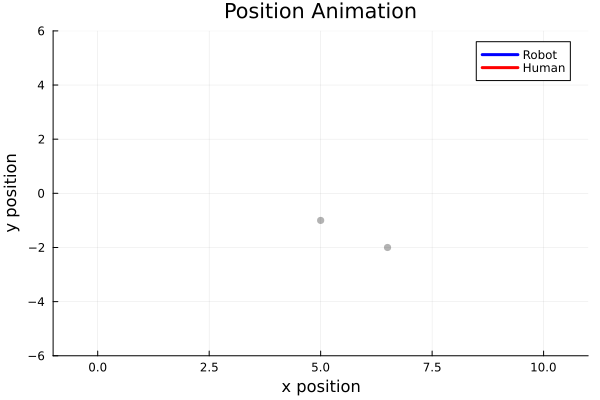

In [111]:
animation(ip, velo_agent_1, velo_agent_2, pos_xlims=[-1, 11], pos_ylims=[-6, 6])

# Simulation Implementation

In [180]:
robot_ip = InteractionPlanner(robot_hps, 
                        human_hps,
                        robot_initial_state,
                        human_initial_state,
                        robot_goal_state,
                        human_goal_state,
                        solver)
# constant velo agents
velo_agent_1 = ConstantVeloAgent([5., -1.], [-0.3, 1.1])
velo_agent_2 = ConstantVeloAgent([6.5, -2.], [-0.9, 0.4])
velo_agent_3 = ConstantVeloAgent([-5., 2], [0.3, -0.8])

add_constant_velocity_agent(robot_ip.ego_planner.incon, velo_agent_1, velo_agent_2, velo_agent_3)
add_constant_velocity_agent(robot_ip.other_planner.incon, velo_agent_1, velo_agent_2, velo_agent_3)

human_ip = InteractionPlanner(human_hps, 
                        robot_hps,
                        human_initial_state,
                        robot_initial_state,
                        human_goal_state,
                        robot_goal_state,
                        solver)
# constant velo agents
velo_agent_1 = ConstantVeloAgent([5., -1.], [-0.3, 1.1])
velo_agent_2 = ConstantVeloAgent([6.5, -2.], [-0.9, 0.4])

add_constant_velocity_agent(human_ip.ego_planner.incon, velo_agent_1, velo_agent_2, velo_agent_3)
add_constant_velocity_agent(human_ip.other_planner.incon, velo_agent_1, velo_agent_2, velo_agent_3)

In [181]:
robot_params = PlannerParams(robot_ip.ego_planner.incon.hps, robot_ip.ego_planner.incon.opt_params)
human_params = PlannerParams(human_ip.ego_planner.incon.hps, human_ip.ego_planner.incon.opt_params)
sim_params = IPSimParams(robot_params, human_params)

IPSimParams(PlannerParams(PlannerHyperparameters{Float64}
  dynamics: DynamicallyExtendedUnicycle{Float64}
  time_horizon: Int64 25
  Q: Array{Float64}((4, 4)) [0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0]
  R: Array{Float64}((2, 2)) [1.0 0.0; 0.0 0.1]
  Qt: Array{Float64}((4, 4)) [1.0 0.0 0.0 0.0; 0.0 1.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0]
  markup: Float64 1.0
  collision_slack: Float64 350.0
  trust_region_weight: Float64 5.0
  inconvenience_weights: Array{Float64}((3,)) [1.0, 1.0, 0.01]
  collision_radius: Float64 1.0
  inconvenience_ratio: Float64 0.3
, PlannerOptimizerParams{Float64}
  As: Array{Matrix{Float64}}((25,))
  Bs: Array{Matrix{Float64}}((25,))
  Cs: Array{Vector{Float64}}((25,))
  Gs: Array{Vector{Float64}}((26,))
  Hs: Array{Float64}((26,)) [-1.0000000407413268, -1.63857956663918, -2.1272442273720458, -2.487097518791984, -2.7372349260975852, -2.894870083069975, -2.975422494134307, -2.9927226839702143, -2.959119131002012, -2.8855957715712

In [182]:
robot_xs, robot_us, human_xs, human_us = simulate(robot_ip, human_ip, 50, velo_agent_1, velo_agent_2, velo_agent_3)

([-10.0 0.0 0.0 2.0; -9.79708615677072 0.0 5.452942071625399e-10 2.0582768645856; … ; 3.6576735389612587 0.30052017327956926 -0.04650298478223452 2.987064245364796; 3.9558411513201537 0.28664448571144213 -0.046669868647739726 2.9827417737715916], [5.4529420716253995e-9 0.5827686458560031; -8.070468519871079e-5 0.5727113164014617; … ; -0.0019678060945185452 -0.032341206959868245; -0.001668838655052068 -0.043224715932044695], [10.0 0.0 3.141592653589793; 9.742212982870097 3.156980453898795e-17 3.1415876995674985; … ; -4.251517176309351 -0.3362111200467322 3.0842965315621576; -4.493618257451808 -0.322324467719982 3.0841532029079226], [-4.9540222945843566e-5 2.5778701712990286; 0.8873567063469614 2.846653966957375; … ; -0.002063601711193178 2.4797813063328373; -0.0014332865423514669 2.4249901567468406])

In [183]:
sim_data = SimData(sim_params, robot_xs, robot_us, human_xs, human_us)

SimData(IPSimParams(PlannerParams(PlannerHyperparameters{Float64}
  dynamics: DynamicallyExtendedUnicycle{Float64}
  time_horizon: Int64 25
  Q: Array{Float64}((4, 4)) [0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0]
  R: Array{Float64}((2, 2)) [1.0 0.0; 0.0 0.1]
  Qt: Array{Float64}((4, 4)) [1.0 0.0 0.0 0.0; 0.0 1.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0]
  markup: Float64 1.0
  collision_slack: Float64 350.0
  trust_region_weight: Float64 5.0
  inconvenience_weights: Array{Float64}((3,)) [1.0, 1.0, 0.01]
  collision_radius: Float64 1.0
  inconvenience_ratio: Float64 0.3
, PlannerOptimizerParams{Float64}
  As: Array{Matrix{Float64}}((25,))
  Bs: Array{Matrix{Float64}}((25,))
  Cs: Array{Vector{Float64}}((25,))
  Gs: Array{Vector{Float64}}((26,))
  Hs: Array{Float64}((26,)) [3.71954816104531, 3.573494533061222, 3.3705545308895353, 3.110674058749794, 2.7937018573344687, 2.419370185424171, 1.9872922319148074, 1.4969587095349937, 0.947731674486306, 0.338835685425294

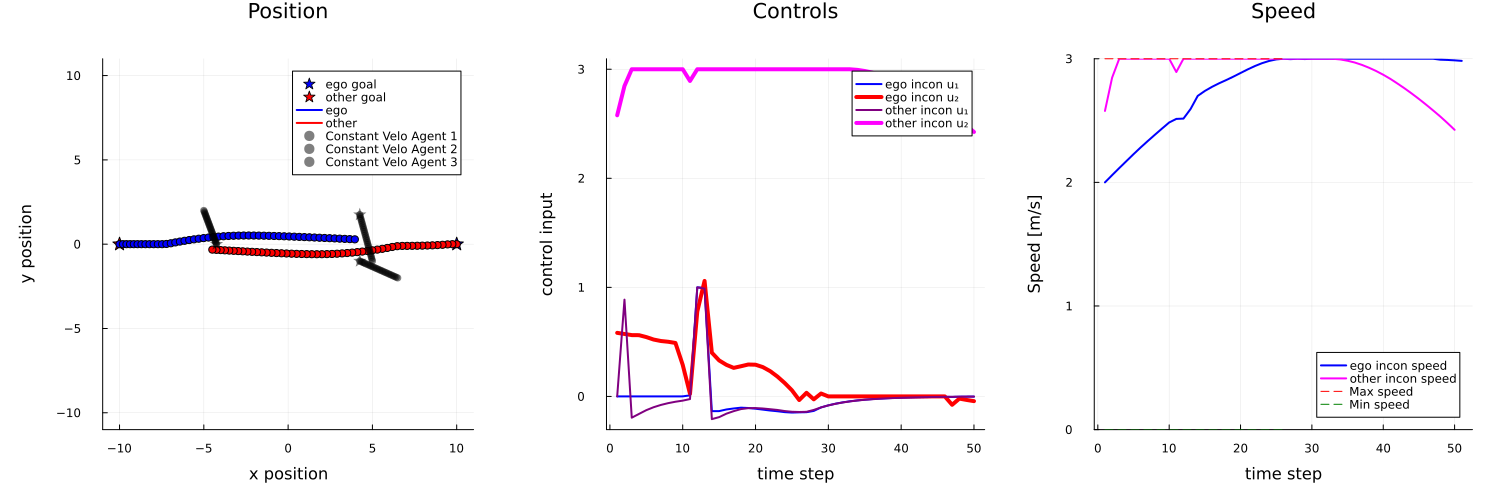

In [184]:
plot_solve_solution(sim_data, velo_agent_1, velo_agent_2, velo_agent_3, pos_xlims=[-11, 11], pos_ylims=[-11, 11])

In [149]:
# bad plotting code but used for animation demonstration

function animation(ego_path::Matrix{Float64}, other_path::Matrix{Float64}, dt::Float64, constant_velo_agents::ConstantVeloAgent...; pos_xlims=[-1, 8], pos_ylims=[-3, 3], save_name="none")
    a = Animation()

    linewidth = 3
    alpha_ideal = 0.2
    ego_color = :blue
    other_color = :red

    markersize=20

    ego_xs = ego_path
    other_xs = other_path

    time_steps = length(ego_path[:, 1])

    N_velo_agents = length(constant_velo_agents)
    constant_velo_agents_pos = Vector{Matrix{Float64}}(undef, N_velo_agents)
    
    for i in 1:N_velo_agents
        pos = constant_velo_agents[i].pos
        velo = constant_velo_agents[i].velo
        constant_velo_agents_pos[i] = vector_of_vectors_to_matrix([pos + velo * dt * j for j in 0:time_steps])
    end

    print(length(constant_velo_agents_pos[1]))

    constant_velo_length = length(constant_velo_agents_pos[1][:, 1])

    plt = plot(xlim=pos_xlims, ylim=pos_ylims, xlabel="x position", ylabel="y position", title="Position Animation", arrow=true, aspect_ration=:equal)


    for i in 1:length(ego_xs[:, 1]) - 1
        plt = plot(ego_xs[1:i,1], ego_xs[1:i,2], color=ego_color, linewidth=linewidth, lab="Robot Path", xlim=pos_xlims, ylim=pos_ylims, xlabel="x position", ylabel="y position", title="Position Animation", margin=10mm, titlefontsize=20, legendfontsize=13, labelfontsize=13, axisfontsize=13)
        plot!(plt, other_xs[1:i,1], other_xs[1:i,2], size=(1200, 800), color=other_color, linewidth=linewidth, lab="Human Path")
        scatter!(plt, ego_xs[i:i, 1], ego_xs[i:i, 2], color=:blue, alpha=0.3, markersize=markersize, label="Robot")
        scatter!(plt, other_xs[i:i, 1], other_xs[i:i, 2], color=:red, alpha=0.3, markersize=markersize, label="Human")

        scatter!(plt, [10000.], [10000.], color=:black, alpha=0.3, markersize=10, label="Non-interactive Humans")

        if i <= constant_velo_length
            for j in 1:N_velo_agents
                scatter!(plt, constant_velo_agents_pos[j][i:i, 1], constant_velo_agents_pos[j][i:i, 2], label="", color=:black, alpha=0.3, markersize=markersize)
            end
        end
        frame(a, plt)
    end

    if save_name != "none"
        gif(a, "../animations/$save_name.gif", fps = 10) 
    end 

    return gif(a, fps=15)
end

animation (generic function with 4 methods)

144

┌ Info: Saved animation to /var/folders/s8/1dzh2b4j4sl22t75kx4fd57m0000gn/T/jl_5E9K9yJ09a.gif
└ @ Plots /Users/jaspergeldenbott/.julia/packages/Plots/3BCH5/src/animation.jl:156


Plots.AnimatedGif("/var/folders/s8/1dzh2b4j4sl22t75kx4fd57m0000gn/T/jl_5E9K9yJ09a.gif")
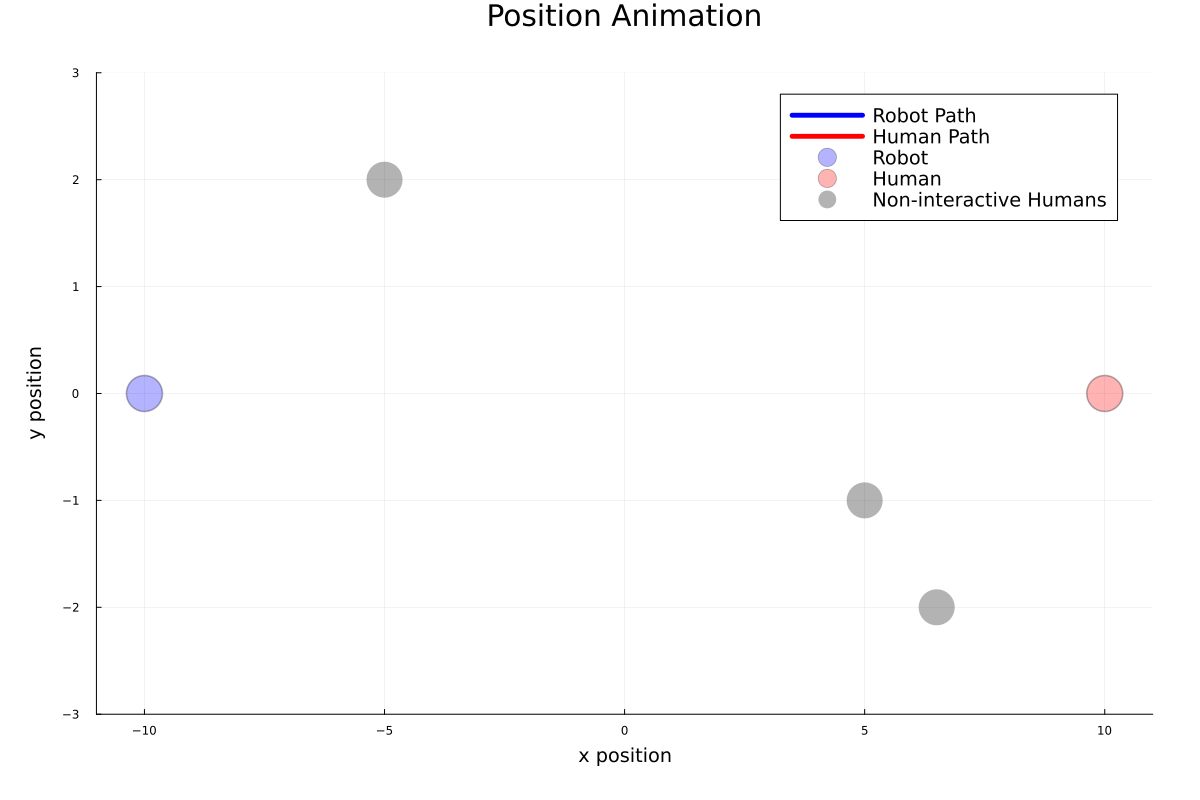

In [160]:
animation(robot_xs, human_xs, 0.1, velo_agent_1, velo_agent_2, velo_agent_3, pos_xlims=[-11, 11])